In [419]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from dateutil.parser import parse 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

## Import data

In [420]:
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
df.rename(columns={'#Passengers': 'value'}, inplace=True)

In [421]:
df.head()

,value
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Дані про кількість пасажирів аеропорту по місяцях.

## Function for drawing

In [422]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(7,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

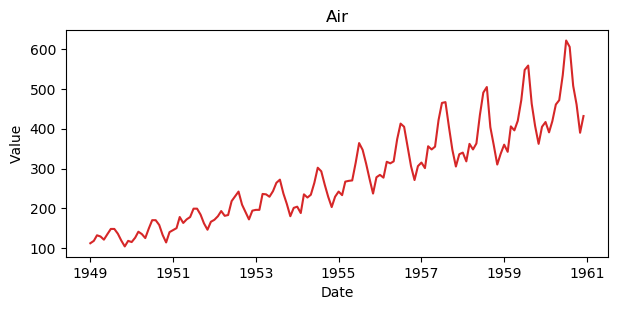

In [423]:
plot_df(df, x=df.index, y=df.values, title='Air')    

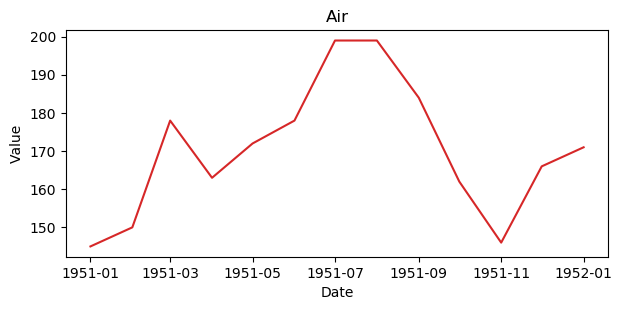

In [424]:
df_part = df['1951-01-01':'1952-01-01']
plot_df(df_part, x=df_part.index, y=df_part.values, title='Air')    

## Decompose series

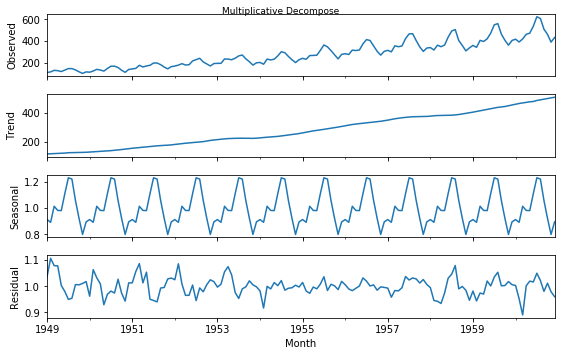

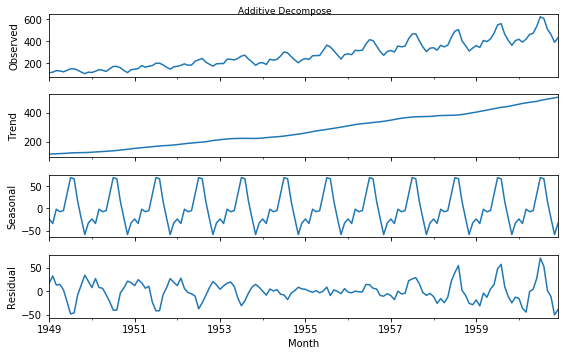

In [425]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=9)
result_add.plot().suptitle('Additive Decompose', fontsize=9)
plt.show()

У даних бачимо і тренд і сезонність. З роками кількість пасажирів збільшується, а також бачимо, що влітку пасажирів найбільше. Можемо сказати, що ряд не стаціонарний. Використаємо також ADH Test для перевірки гіпотези про нестаціонарність. 

## Check for stationary

In [426]:
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.8153688792060518
p-value: 0.991880243437641
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Бачимо що P-Value більше ніж 0.5, тому ряд не стаціонарний

Далі побудуємо автокореляційну функцію та спектр

## Autocorrelation

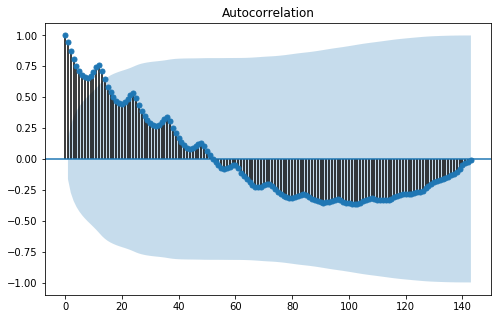

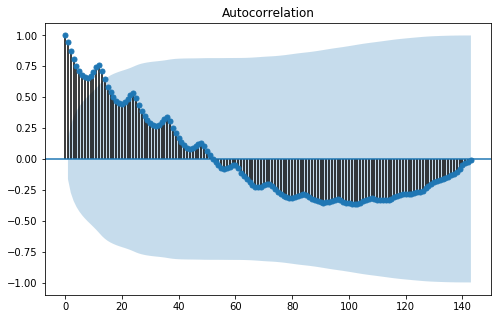

In [427]:
plot_acf(df)

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


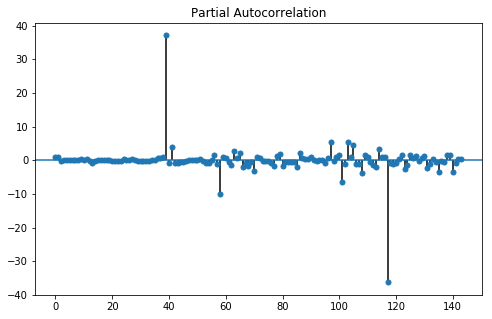

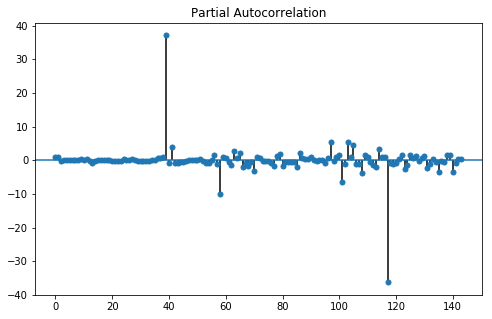

In [428]:
plot_pacf(df)

## Spectrum

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


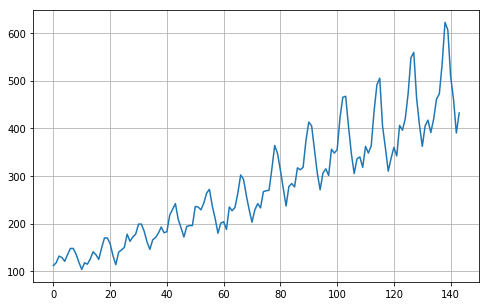

In [429]:
freq = fft(df)
plt.plot(freq)
plt.grid()
plt.show()

## Energy

In [430]:
E =  np.mean(freq**2)
E

(92859.28472222222+0j)

## Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020554ECDF60>]],
      dtype=object)

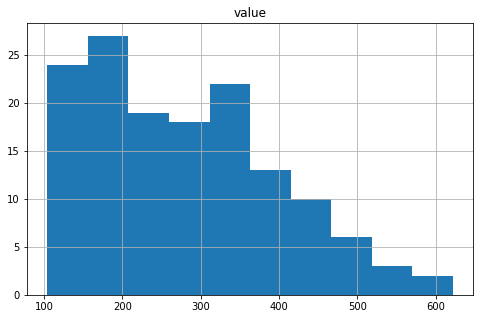

In [431]:
df.hist()

## Train_test split

Розділимо дані на трейн та тест датасети

In [432]:
train = df[:'1958-07-01']
test = df['1958-07-01':]

# Models

Обрані моделі: ARIMA, ARMA, SARIMAX

## ARIMA

In [434]:
model = ARIMA(train.value, order=(4,1,7))
fitted = model.fit(disp=0)
print(model_fit.summary())

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  114
Model:                 ARIMA(4, 1, 7)   Log Likelihood                -478.603
Method:                       css-mle   S.D. of innovations             14.825
Date:                Sun, 26 May 2019   AIC                            983.207
Time:                        22:45:46   BIC                           1018.777
Sample:                    02-01-1949   HQIC                           997.643
                         - 07-01-1958                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2590      0.627      3.604      0.000       1.031       3.487
ar.L1.D.value     1.8090      0.096     18.937      0.000       1.622       1.996
ar.L2.D.value    -1.6530      0.201     

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


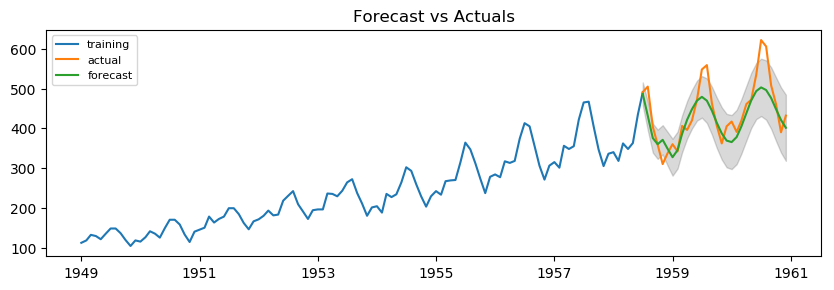

In [435]:
# Forecast
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(10,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

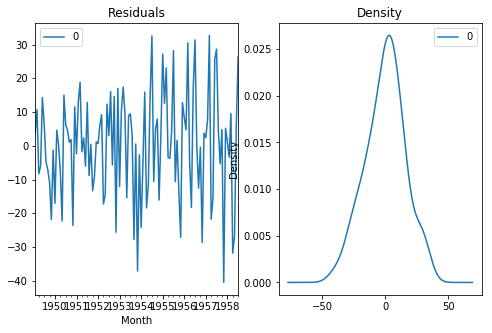

In [436]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [437]:
rmse = np.mean((fc - test.values)**2)**.5  # RMSE
print('RMSE: ', rmse)

RMSE:  94.75751724459805


## ARMA

In [438]:
model = ARMA(train.value, order=(3,1,7))
fitted = model.fit(disp=0)
print(model_fit.summary())

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  114
Model:                 ARIMA(4, 1, 7)   Log Likelihood                -478.603
Method:                       css-mle   S.D. of innovations             14.825
Date:                Sun, 26 May 2019   AIC                            983.207
Time:                        22:45:49   BIC                           1018.777
Sample:                    02-01-1949   HQIC                           997.643
                         - 07-01-1958                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2590      0.627      3.604      0.000       1.031       3.487
ar.L1.D.value     1.8090      0.096     18.937      0.000       1.622       1.996
ar.L2.D.value    -1.6530      0.201     

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


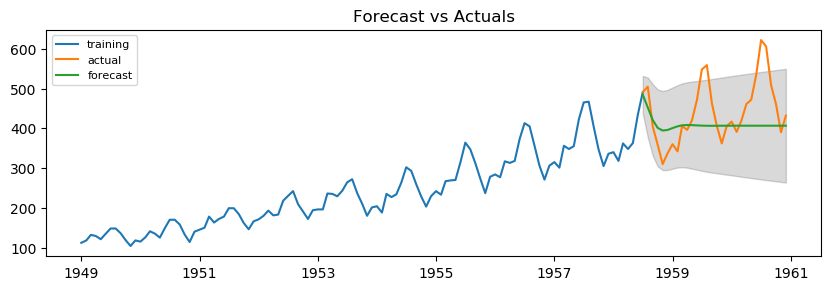

In [439]:
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(10,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

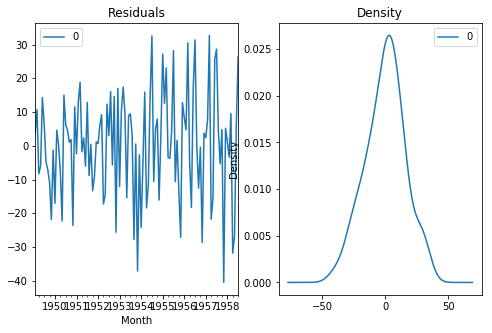

In [440]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [441]:
rmse = np.mean((fc - test.values)**2)**.5  # RMSE
print('RMSE: ', rmse)

RMSE:  85.30455678313787


## SARIMAX

In [442]:
model = SARIMAX(train.value, order=(4,1,7))
fitted = model.fit(disp=0)
print(model_fit.summary())

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  114
Model:                 ARIMA(4, 1, 7)   Log Likelihood                -478.603
Method:                       css-mle   S.D. of innovations             14.825
Date:                Sun, 26 May 2019   AIC                            983.207
Time:                        22:45:53   BIC                           1018.777
Sample:                    02-01-1949   HQIC                           997.643
                         - 07-01-1958                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2590      0.627      3.604      0.000       1.031       3.487
ar.L1.D.value     1.8090      0.096     18.937      0.000       1.622       1.996
ar.L2.D.value    -1.6530      0.201     

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


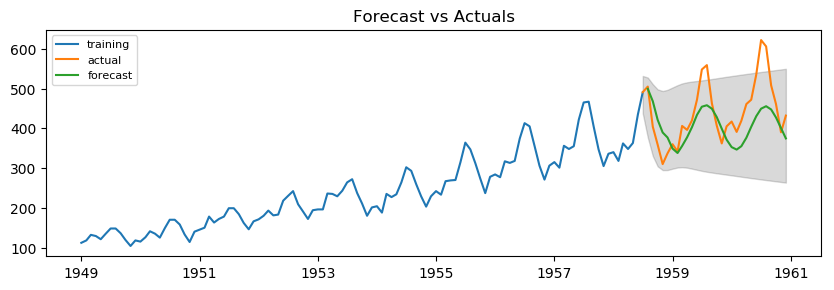

In [443]:
# Forecast
fc = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(10,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

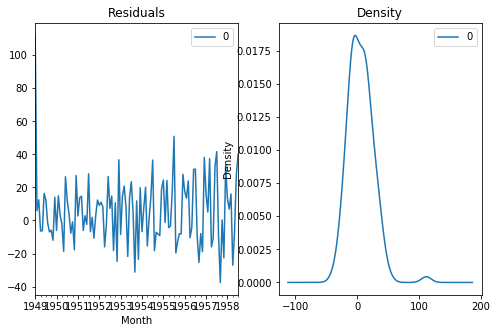

In [444]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [445]:
rmse = np.mean((fc.values - test.values)**2)**.5  # RMSE
print('RMSE: ', rmse)

RMSE:  95.88151099102356


Бачимо, що ARIMA і SARIMAX показали майже одинакові результати. Хоча RMSE у ARMA найменший, але візуально можемо бачити, що ARIMA і SARIMAX справилися краще